## Overview

In machine learning, we often want to know 1) which features are most predictive of a target, and 2) which features contribute most to a given prediction.  The former is crucial to knowing which features we can afford to ignore when fitting a model, and the latter is important from a business perspective and model interpretability.  Both can be obtained by analyzing the **feature importance** of a dataset.

How do we quantify feature importance?  One simple method is to look at how correlated a feature is with the target.  We could also perform PCA to see how influential a feature is in terms of its contribution to the variance of a principal component.  More importantly, we could look at how an altered form of that feature -- either by dropping it altogether or by scrambling its observations -- affects the outcome of a model.  A model that performs worse (in terms of predictive ability) with the altered feature likely means that feature is important to some degree.  In other words, having that particular feature in our dataset contributes significantly to how well a model trained with that feature is able to predict the target.

The following sections explore several feature importance methods and how we could use feature importance to better understand the data in front of us.

In [609]:
%run featimp.py

In [559]:
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## Datasets

The _Boston house prices_ and _Diabetes_ data sets from `scikit-Learn` provide good examples to work with.  Both are intended for regression models (we could also use classification datasets; however, feature importance is best demonstrated with regression).

In [561]:
df_boston = _load_boston()
df_diabetes = _load_diabetes()

In [563]:
df_boston.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


The [Boston](https://scikit-learn.org/stable/datasets/index.html#boston-dataset) dataset contains 13 features; the target is house price (in $1000).

In [564]:
df_diabetes.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


The [Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) dataset contains 10 features; the target is a quantitative measure of disease progression one year after baseline.

## Measures of feature importance

### Spearman's rank correlation coefficient

Perhaps the simplest method is to rank each feature's importance using Spearman's rank correlation coefficient.  Note that we don't use Pearson's correlation coefficient because our aim is to quantify the _monotonicity_ of the relationship between a feature and the target is, regardless of how _linear_ the realtionship is.  Spearman's rank correlation coefficient is calculated by ranking the feature and target by their values, then taking a correlation coefficient between the ranks themselves.

Boston dataset feature importances based on Spearman's rank correlation:

In [552]:
rank_features_spearman(df_boston, 'target')

,feature,target
0,LSTAT,0.852914
1,RM,0.633576
2,INDUS,0.578255
3,NOX,0.562609
4,TAX,0.562411
5,CRIM,0.558891
6,PTRATIO,0.555905
7,AGE,0.547562
8,DIS,0.445857
9,ZN,0.438179


### Principal component analysis (PCA)

We can also measure feature importance with principal component analysis (PCA).  Typically used for clustering, PCA can potentially help us discern important features if the first principal component accounts for a sizable portion of the observed variance.  Specifically, the absolute value of the elements in the first component is a proxy for how important the corresponding features are.

Boston dataset feature importances based on PCA:

In [586]:
rank_features_pca(df_boston, 'target', n_components=1)

,feature,var_explained
0,INDUS,0.346672
1,NOX,0.342852
2,TAX,0.338469
3,DIS,0.321544
4,RAD,0.319793
5,AGE,0.313671
6,LSTAT,0.309760
7,ZN,0.256315
8,CRIM,0.250951
9,PTRATIO,0.204942


Clearly, computing feature importances using PCA yields significantly different results than computing with Spearman's rank correlation.

### Ordinary least squares (OLS)

In ordinary least squares (OLS) feature importance, we fit a linear regression model to our data, then simply look at the magnitude of our coefficients.  Sorting the coefficients gives us the feature importance ranking.  Note that features with large _negative_ coefficients can be most important, since we are considering the absolute value of the coefficients.

Boston dataset feature importances based on OLS:

In [554]:
rank_features_ols(df_boston, 'target')

,feature,coef
0,LSTAT,-3.743627
1,DIS,-3.104044
2,RM,2.674230
3,RAD,2.662218
4,TAX,-2.076782
5,PTRATIO,-2.060607
6,NOX,-2.056718
7,ZN,1.081569
8,CRIM,-0.928146
9,B,0.849268


### Drop-column

The principle behind drop-column importance is to find out how much a particular feature affects model performance if it is removed entirely from the training data.  Intuitively, the worse a model performs after the feature was dropped, the more important that feature is; i.e. the more that feature contributes to the predictive ability of the model.  The procedure is as follows:

  1. Fit a model to the training set containing all columns.
  2. Record the _baseline metric_ (e.g. MSE, log-loss) using out-of-bag (OOB) samples or a validation set.
  3. Drop a feature from the training set.
  4. Refit the same model.
  5. Record the _drop-column metric_ using OOB samples or a validation set.
  6. Compute the difference between the _drop-column metric_ and _baseline metric_.  This is our measure of importance for this particular feature.
  7. Repeat (3) - (6) for all features.
  
One major pitfall of drop-column importance is that columns that are highly correlated with each other tend to appear least important.  This is because dropping a column has little to no effect on model performance if there is another column to "cover" for it, i.e. the _baseline metric_ and _drop-column metric_ for related features are similar.

Boston dataset feature importances based on drop-column importance:

In [556]:
rank_features_drop(df_boston, 'target', 'reg')

,feature,drop_importance
12,LSTAT,0.081399
5,RM,0.043901
4,NOX,0.008519
7,DIS,0.008078
10,PTRATIO,0.007111
0,CRIM,0.002071
9,TAX,0.001978
2,INDUS,0.000534
8,RAD,0.000259
11,B,0.000172


### Column permutation

The principle behind pemutation importance is to find out how much a particular feature affects model performance if it _permuted_, or shuffled, in place.  Intuitively, the worse a model performs after the feature was permuted, the more important that feature is; i.e. the more that feature contributes to the predictive ability of the model.  The procedure is as follows:

  1. Fit a model to the training set.
  2. Record the _baseline metric_ (e.g. MSE, log-loss) using out-of-bag (OOB) samples or a validation set.
  3. Permute a feature from the training set.
  4. Record the _permuted-column metric_ using OOB samples or a validation set.
  5. Compute the difference between the _permuted-column metric_ and _baseline metric_.  This is our measure of importance for this particular feature.
  6. Repeat (3) - (5) for all features.
  
One key advantage of permutation importance is speed, as we only need to fit a model once as opposed to _p_ times where _p_ is the number of features.  It is postulated that columns that are highly related "share" their collective permutation importance; e.g. two columns that are related likely have a similar permutation importance that is half of what it would be if one of the columns were dropped from the training set.

Boston dataset feature importances based on permutation importance:

In [610]:
rank_features_perm(df_boston, 'target', 'reg')

,feature,perm_importance
12,LSTAT,0.928985
5,RM,0.573363
10,PTRATIO,0.025119
4,NOX,0.022267
0,CRIM,0.018087
6,AGE,0.017928
7,DIS,0.011563
9,TAX,0.007282
11,B,0.001643
2,INDUS,0.000719


## Comparing importance measures

Let's compare how "good" these measures of feature importances are.  We gather ranked feature importances using the methods described above, and plot validation metrics of a model fitted on the _k_ most important features.  Note that each feature importance method will produce a different ranking of features; for instance, the three most important features computed with _OLS_ might not be the same as those computing with _drop-column_.  Feature importance methods that yield rankings in such a way that fitting a model on the top most important features already results in a relatively high metric can be considered "better", or more robust, than others.

Note also that features fitted on different models will result in different validation metrics.  Here, we plot validation r2 score against the number of chosen features in the Boston dataset fit to a RandomForest, XGBoost, and OLS model.

In [ ]:
# RandomForest
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1,
                            min_samples_leaf=10, random_state=3)
rfr_scores = get_importance_matrix(df_boston, 'target', rfr, 'r2', 'reg')
rfr_scores['model'] = 'RF'
rfr_scores.index = [i for i in range(len(rfr_scores))]

# XGBoost
xgbr = XGBRegressor(n_estimators=100, max_depth=2, n_jobs=-1,
                    random_state=3, objective ='reg:squarederror')
xgbr_scores = get_importance_matrix(df_boston, 'target', xgbr, 'r2', 'reg')
xgbr_scores['model'] = 'XGB'
xgbr_scores.index = [i for i in range(len(xgbr_scores))]

# OLS
X = df_boston.drop('target', axis=1)
y = df_boston['target']
ols = sm.OLS(y, X)
ols_scores = get_importance_matrix(df_boston, 'target', ols, 'r2', 'reg')
ols_scores.index = [i for i in range(len(ols_scores))]
ols_scores['model'] = 'OLS'

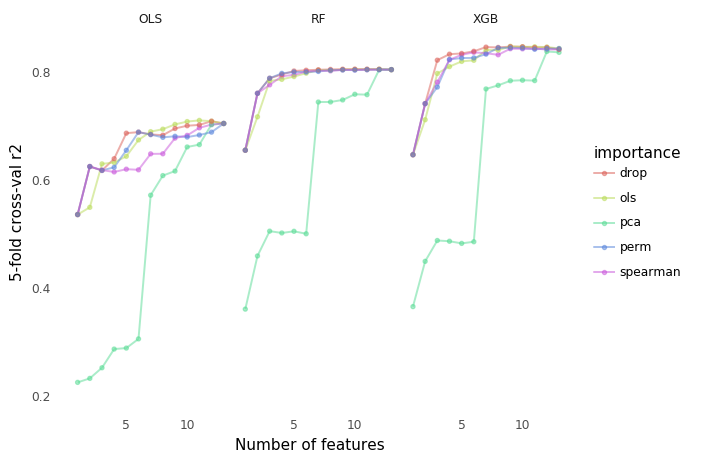

<ggplot: (7564845418)>

In [591]:
all_scores = pd.concat([rfr_scores, xgbr_scores, ols_scores])

(pn.ggplot(all_scores,
           pn.aes('num_features', 'mean_val_r2', color='importance'))
 + pn.geom_line(alpha=0.5, size=0.8)
 + pn.geom_point(alpha=0.5, size=1.2)
 + pn.facet_wrap('~ model', nrow=1, ncol=3)
 + pn.labs(x='Number of features', y='5-fold cross-val r2')
 + pn.theme_minimal()
 + pn.theme(panel_grid = pn.element_blank())
)

When fitting OLS, RandomForest, and XGBoost models on the top _k_ features determined by each importance measure, it is clear that PCA is the least accurate measure of importance.  Taking the average 5-fold cross validation score, we see that using even the top five or six features (as determined by PCA) to fit our models results in r2 scores that are less than half of those using other measures of importance.  Other measures seem to perform similarly (and well) for RandomForest and XGBoost; the OLS model produces the most variation in r2 scores across the different importance measures as _k_ increases.  This plot also shows us that in general, XGBoost seems to be the best model -- of course, not considering hyperparameter tuning -- out of the three in terms of of average r2 score.

## Automatic feature selection

As machine learning practitioners, we often wish to use the minimum number of features possible while still achieving the highest (or high enough) metric possible.  One way to do this is to rank features by importance (using some kind of feature importance method) and start dropping, one by one, the least important feature until our validation metric starts to drop below the baseline metric.  We are left with the minimum set of features needed to still perform well on validation.  The procedure is as follows:

1. Fit a model to the training data and get a baseline metric.
2. Get feature importances.
3. Drop the least important feature.
4. Refit the model to the remaining features and record validation metric.
5. If the validation metric is worse than the baseline metric, stop (and include the dropped column in the columns to keep).
6. Repeat (2) - (5) until we have dropped as many features as possible.
7. Return kept features.

Note that we must recompute feature importances each iteration since there might be codependencies between features.

In [491]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
important_feats = auto_feature_select(df_boston, 'target', rf, mean_squared_error)

In [ ]:
from collections import Counter

kept_features = []
num_iter = 30
for i in range(30):
    print(i)
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    important_feats = auto_feature_select(df_boston, 'target', rf,
                                          mean_squared_error)
    for feat in important_feats:
        kept_features.append(feat)

In [541]:
counts = Counter(kept_features).most_common()
features = [x[0] for x in counts]
counts = np.array([x[1] for x in counts]) / num_iter
kept_feat_counts = pd.DataFrame({'feature': features, 'count': counts}) \
                     .sort_values('count')

sorted_feats = list(kept_feat_counts['feature'])
kept_feat_counts['feature'] = pd.Categorical(sorted_feats, ordered=True,
                                             categories=sorted_feats)

Here we run automatic feature selection on the Boston dataset 30 times and plot the percentage of times each feature was kept.  The features `LSTAT`, `PTRATIO`, `RM`, and `NOX` were kept all 30 trials, whereas `CHAS` was only kept approximately 62% of the time.  Just by inspection, this indicates that perhaps a quarter of the features in the Boston dataset can be discarded if we are looking to achieve a decent validation metric.

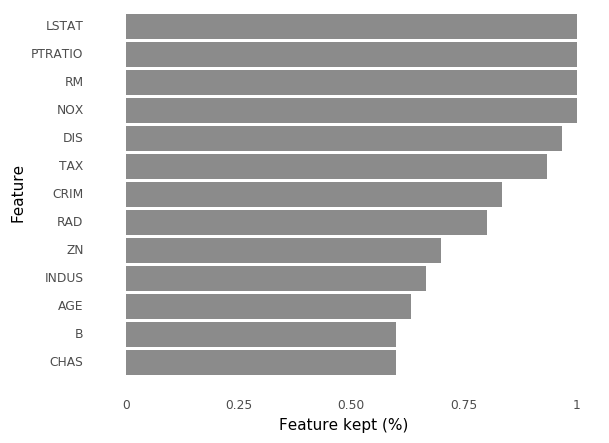

<ggplot: (7560150767)>

In [603]:
(pn.ggplot(kept_feat_counts, pn.aes('feature', 'count'))
 + pn.geom_col(alpha=0.7)
 + pn.labs(x='Feature', y='Feature kept (%)')
 + pn.theme_minimal()
 + pn.theme(panel_grid = pn.element_blank())
 + pn.coord_flip()
)

## Visualizing feature importance

Having clear, compelling visualizations of feature importance is a huge benefit to data science practitioners of all levels.  Perhaps most logical is the horizontal barplot, sorted by importance.  We can utilize `ggplot` to make visualizations snappy and proportional for easy skimming.

Below is an example for permutation importance computed on the Diabetes dataset.

In [671]:
ranks = rank_features_perm(df_diabetes, 'target', 'reg').sort_values('perm_importance')
ranks['rel_frac'] = round(ranks['perm_importance'] / ranks.iloc[-1, 1] * 100, 1).astype(str) + '%'
sorted_feats = list(ranks['feature'])
ranks['feature'] = pd.Categorical(sorted_feats, ordered=True, categories=sorted_feats)
max_imp = ranks.iloc[-1, 1]

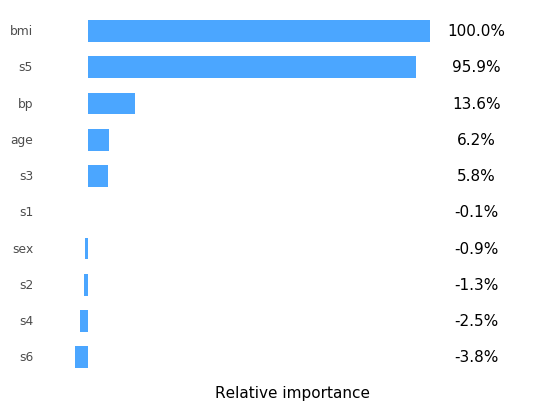

<ggplot: (7564791942)>

In [717]:
(pn.ggplot(ranks, pn.aes('feature', 'perm_importance'))
 + pn.geom_col(alpha=0.8, fill='dodgerblue', width = 0.6)
 + pn.geom_text(pn.aes(label='rel_frac', y=max_imp+0.03))
 + pn.expand_limits(y=0.28)
 + pn.labs(y='Relative importance', x=None)
 + pn.theme_minimal()
 + pn.theme(panel_grid=pn.element_blank(),
            axis_text_x=pn.element_blank())
 + pn.coord_flip()
)